# Gas Consumption Forecasting

In [ ]:
#libaries

#data elt and viz
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import plot_tree

#data split and scoring
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

#feature scaling
from sklearn.preprocessing import StandardScaler

#ML models
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier

## Prepare Data

In [ ]:
df = pd.read_csv('gas_data.csv')
df.columns = ['fy', 'date', 'fixed', 'floating', 'trades', 'day_ahead', 'imbalance', 'total' ]

Old Energia Bills
1. fixed: site consumption
2. floating: hedging

New Electric Ireland Bills
1. Allocated Consumption: actual consumption for the month, made up of hedging and site consumption
2. Trades: site consumption
3. Day Ahead (hedge): hedging
4. Nominated Consumption: allowed for site
5. Imbalance: unused consumption

In [ ]:
df.head()

,fy,date,fixed,floating,trades,day_ahead,imbalance,total
0,19.0,Oct-18,"784,951","431,192",-,-,-,"1,216,143"
1,19.0,Nov-18,"3,398,160","-1,531,994",-,-,-,"1,866,166"
2,19.0,Dec-18,"3,372,428","-736,426",-,-,-,"2,636,002"
3,19.0,Jan-19,"4,964,154","-2,423,318",-,-,-,"2,540,836"
4,19.0,Feb-19,"4,546,136","-1,610,016",-,-,-,"2,936,120"


In [ ]:
df['consumption'] = df['fixed'].combine_first(df['trades'])
df.drop(columns=['fy', 'fixed', 'floating', 'trades', 'day_ahead', 'imbalance', 'total'], inplace=True)
df.head()

,date,consumption
0,Oct-18,"784,951"
1,Nov-18,"3,398,160"
2,Dec-18,"3,372,428"
3,Jan-19,"4,964,154"
4,Feb-19,"4,546,136"


In [ ]:
df['date'] = pd.to_datetime(df['date'], format='%b-%y', errors='coerce')
df['consumption'] = df['consumption'].str.replace(',','').str.strip()
df['consumption'] = pd.to_numeric(df['consumption'], errors='coerce')
df.head()

,date,consumption
0,2018-10-01,784951.0
1,2018-11-01,3398160.0
2,2018-12-01,3372428.0
3,2019-01-01,4964154.0
4,2019-02-01,4546136.0


In [ ]:
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df.head()

,date,consumption,month,year
0,2018-10-01,784951.0,10.0,2018.0
1,2018-11-01,3398160.0,11.0,2018.0
2,2018-12-01,3372428.0,12.0,2018.0
3,2019-01-01,4964154.0,1.0,2019.0
4,2019-02-01,4546136.0,2.0,2019.0


In [ ]:
#define colour map
colourmap = plt.cm.get_cmap('viridis', df['year'].nunique())
years = df['year'].unique()
year_colours = {year: colourmap(i) for i, year in enumerate(years)}

#map colours to df
df['colour'] = df['year'].map(year_colours)
print(years)

[2018. 2019. 2020. 2021. 2022. 2023. 2024.   nan]


<ipython-input-9-10065523d79d>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colourmap = plt.cm.get_cmap('viridis', df['year'].nunique())


In [ ]:
#Remove outlier from previous iteration
df = df[df['consumption']>10**6]

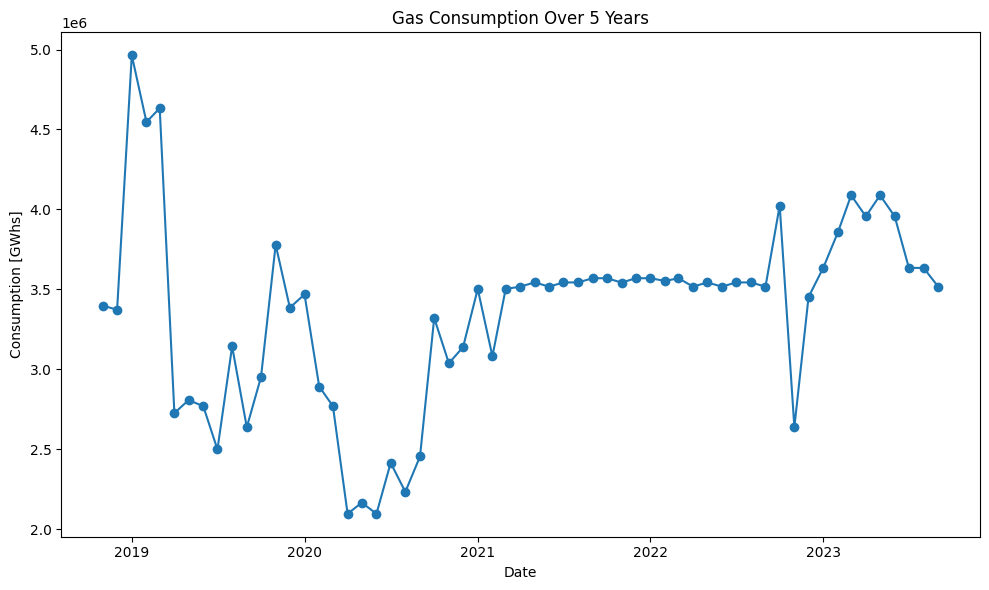

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['consumption'], marker='o', linestyle='-')
plt.title('Gas Consumption Over 5 Years')
plt.xlabel('Date')
plt.ylabel('Consumption [GWhs]')
plt.tight_layout()
plt.show()

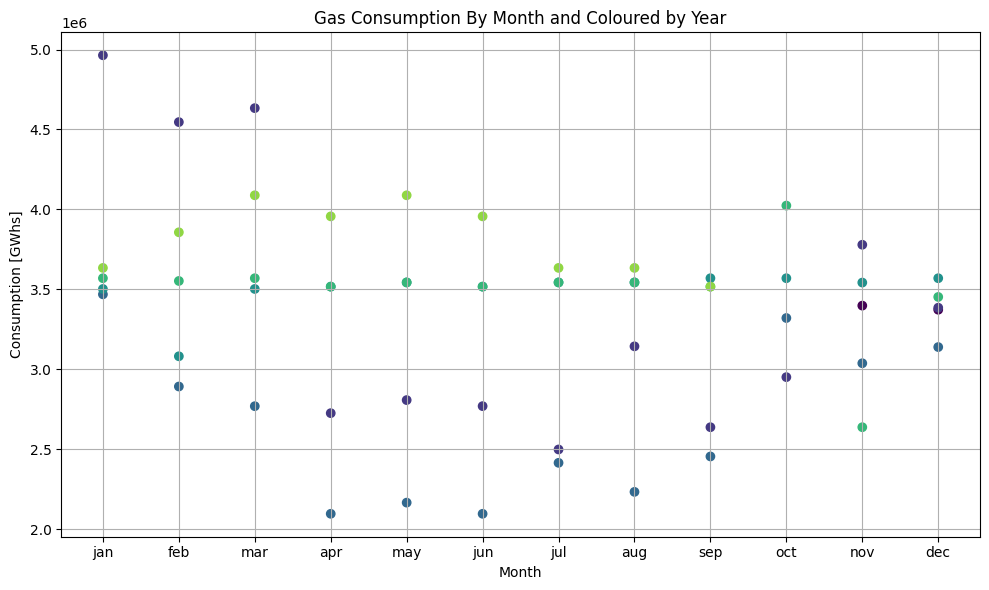

In [ ]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['month'], df['consumption'], c=df['colour'], label=df['year'])

plt.title('Gas Consumption By Month and Coloured by Year')
plt.xlabel('Month')
plt.ylabel('Consumption [GWhs]')

plt.xticks(ticks=range(1,13), labels=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])
plt.grid(True)
plt.tight_layout()
plt.show()

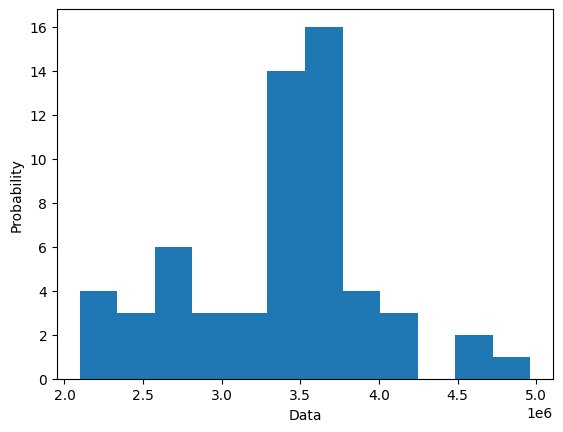

In [ ]:
plt.hist(df['consumption'], density=False, bins=12)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

In [ ]:
monthly_avg_consumption_df = df.groupby('month')['consumption'].mean().reset_index()
monthly_avg_consumption_df.head(12)

,month,consumption
0,1.0,3827774.60
1,2.0,3585774.40
2,3.0,3712578.60
3,4.0,3162360.00
4,5.0,3229611.00
5,6.0,3171150.00
6,7.0,3126765.40
7,8.0,3219430.60
8,9.0,3139140.00
9,10.0,3466226.25


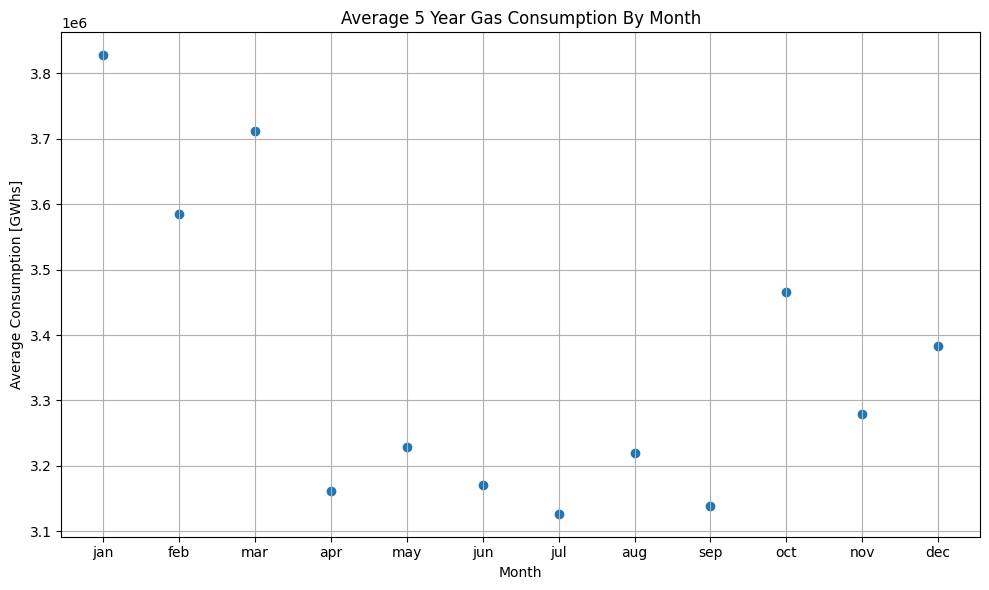

In [ ]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(monthly_avg_consumption_df['month'], monthly_avg_consumption_df['consumption'])

plt.title('Average 5 Year Gas Consumption By Month')
plt.xlabel('Month')
plt.ylabel('Average Consumption [GWhs]')

plt.xticks(ticks=range(1,13), labels=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])
plt.grid(True)
plt.tight_layout()
plt.show()

## Traditional Modelling

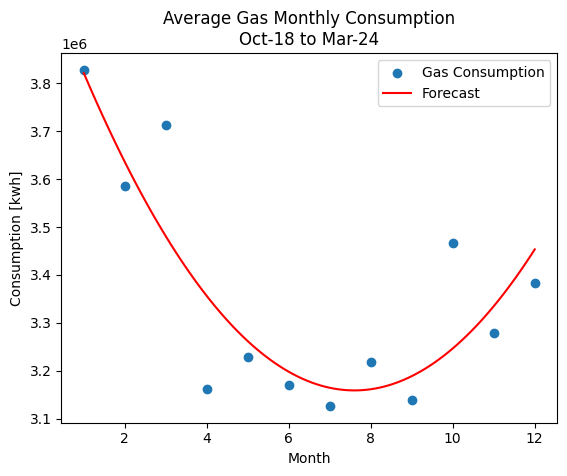

Parabolic equation: 15197.8443 * x^2 + -231005.6022 * x + 4036939.1875


In [ ]:
# Assuming you have your data in df['month'] and df['consumption']
X = monthly_avg_consumption_df['month']
y = monthly_avg_consumption_df['consumption']

# Fit a quadratic function (degree 2) to the data
coeffs = np.polyfit(X, y, 2)

# Get the coefficients (a, b, c)
a, b, c = coeffs

# Create the parabolic equation
equation = f"{a:.4f} * x^2 + {b:.4f} * x + {c:.4f}"

# Visualize the fit
x_fit = np.linspace(min(X), max(X), 100)
y_fit = a * x_fit**2 + b * x_fit + c

plt.scatter(X, y, label='Gas Consumption')
plt.plot(x_fit, y_fit, color='red', label='Forecast')
plt.xlabel('Month')
plt.ylabel('Consumption [kwh]')
plt.title('Average Gas Monthly Consumption\nOct-18 to Mar-24')
plt.legend()
plt.show()

#Equation
print(f"Parabolic equation: {equation}")


In [ ]:
x = int(input('Enter a Month (1-12): '))
forecast = 15197.8443 * x**2 + -231005.6022 * x + 4036939.1875
print(f' month: {x}, forecast consumption: {forecast:,.0f} kwh')

Enter a Month (1-12): 4
 month: 4, forecast consumption: 3,356,082 kwh


## Machine Learning - Polynomial Regression

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree = 2)
X = monthly_avg_consumption_df.iloc[:, :-1].values
x_poly = poly_reg.fit_transform(X)

lin_reg_2 = LinearRegression()
lin_reg_2.fit(x_poly, y)

LinearRegression()

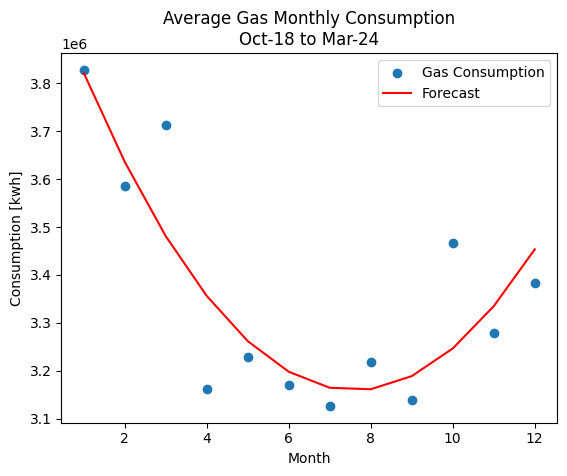

In [ ]:
plt.scatter(X, y, label='Gas Consumption')
plt.plot(X, lin_reg_2.predict(x_poly), color='red', label='Forecast')
plt.xlabel('Month')
plt.ylabel('Consumption [kwh]')
plt.title('Average Gas Monthly Consumption\nOct-18 to Mar-24')
plt.legend()
plt.show()

In [ ]:
x = int(input('Enter a Month (1-12): '))
forecast = lin_reg_2.predict(poly_reg.fit_transform([[x]]))
print(f' month: {x}, forecast consumption: {forecast[0]:,.0f} kwh')

Enter a Month (1-12): 4
 month: 4, forecast consumption: 3,356,082 kwh
